# Section 4


This file runs the experiments and returns the top performing models as a dictionary of hyper-parameters. It also creates all figures in the paper except those specific to the causal PDP and CD diagrams. Rather than countries, we showcase the pipeline using the US Bible Belt states.

In [ ]:
# required modules (skip if already installed)
!pip install lightgbm
!pip install xgboost
!pip install optuna
!pip install scikit_posthocs
!pip install autorank
!pip install pytorch-tabnet

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# local imports
from _utils import *

# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# working directory
os.chdir("..")
wd = os.getcwd()
# data folder
data_path = wd + '/' + 'data' + '/'
# results folder
resu_path = wd + '/' + 'results' + '/'

## The data

In [3]:
# use the prefix 'lar' to identify the individual state data
states = [f for f in os.listdir(data_path) if f.split('_')[0]=='lar']
states

['lar_ak_adult.csv',
 'lar_al_adult.csv',
 'lar_ga_adult.csv',
 'lar_la_adult.csv',
 'lar_ms_adult.csv',
 'lar_nc_adult.csv',
 'lar_ok_adult.csv',
 'lar_sc_adult.csv',
 'lar_tn_adult.csv']

In [4]:
dict_df = {}

for state in states:
#     print(state.split('_')[1].upper())
    dict_df[state.split('_')[1].upper()] = pd.read_csv(os.path.join(data_path, state), sep='|', )
    
df = pd.concat(dict_df).reset_index(drop=True)
del dict_df

df.head(5)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y,STATE
0,32.0,2.0,19.0,5.0,5510.0,2.0,7.0,40.0,2.0,1.0,True,AK
1,61.0,4.0,16.0,1.0,4220.0,2.0,1.0,40.0,1.0,4.0,False,AK
2,65.0,2.0,21.0,1.0,6200.0,2.0,0.0,35.0,1.0,9.0,True,AK
3,38.0,1.0,17.0,4.0,310.0,46.0,0.0,30.0,2.0,1.0,False,AK
4,50.0,1.0,21.0,1.0,3255.0,328.0,0.0,50.0,2.0,2.0,True,AK


In [5]:
"""
AGEP (Age); [cont.] 
COW (Class of worker); [cat.]
SCHL (Educational attainment); [cat.: ordinal] 
MAR (Marital status); [cat.]
OCCP (Occupation); [cat.: ordinal] 
POBP (Place of birth); [cat.]
RELP (Relationship); [cat.]
WKHP (Usual hours worked per week past 12 months); [cont.]
SEX (Sex); [cat.]
RAC1P (Recoded detailed race code) [cat.]
STATE; [cat.: added by us]
"""

target = 'Y'

con_feats = ['AGEP', 'WKHP']
cat_feats = ['COW', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P', 'STATE']
ord_feats = ['SCHL', 'OCCP']
all_feats =  con_feats + cat_feats + ord_feats

print(df.shape)
df.info()

(235893, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235893 entries, 0 to 235892
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AGEP    float64
 1   COW     float64
 2   SCHL    float64
 3   MAR     float64
 4   OCCP    float64
 5   POBP    float64
 6   RELP    float64
 7   WKHP    float64
 8   SEX     float64
 9   RAC1P   float64
 10  Y       bool   
 11  STATE   object 
dtypes: bool(1), float64(10), object(1)
memory usage: 20.0+ MB


In [6]:
# missing values?
if df[df.isna().any(axis=1)].shape[0] > 0:
    # replace missings with mode
    for c in df.columns[df.isnull().any()]:
        df[c].fillna(df[c].mode()[0], inplace=True)
else:
    print('no missing values')

no missing values


In [7]:
# TODO: not fully convinced on the treatment of ordinal vs categorical vars here! 
# check with Salvatore; also: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df['Y'] = df['Y'].map({False: 0, True: 1})
df['SEX'] = df['SEX'].map({2: 'Female', 1: 'Male'})
df['RAC1P'] = df['RAC1P'].map({1: 'White', 2: 'Black', 3: 'Native', 4: 'Native', 5: 'Native', 6: 'Asian', 7: 'Islander', 8: 'Other', 9: 'Mixed'})

# Check which variables are not numeric
print(df.select_dtypes(exclude = np.number).columns)

df.head(5)

Index(['Y', 'STATE'], dtype='object')
Index(['SEX', 'RAC1P', 'STATE'], dtype='object')


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,Y,STATE
0,32.0,2.0,19.0,5.0,5510.0,2.0,7.0,40.0,Female,White,1,AK
1,61.0,4.0,16.0,1.0,4220.0,2.0,1.0,40.0,Male,Native,0,AK
2,65.0,2.0,21.0,1.0,6200.0,2.0,0.0,35.0,Male,Mixed,1,AK
3,38.0,1.0,17.0,4.0,310.0,46.0,0.0,30.0,Female,White,0,AK
4,50.0,1.0,21.0,1.0,3255.0,328.0,0.0,50.0,Female,Black,1,AK


In [30]:
df['AGEP'].describe()

count    235893.000000
mean         43.209438
std          15.144979
min          17.000000
25%          30.000000
50%          43.000000
75%          55.000000
max          94.000000
Name: AGEP, dtype: float64

In [ ]:
# Discretize AGEP for descriptive stats? Create the new var AGE

def f(x):
    if x==1:
        return '0-17'
    if x==2:
        return '18-24'
    if x==3:
        return '25-34'
    if x==4:
        return '35-44'
    if x==5:
        return '45-54'
    if x==6:
        return '55-65'
    if x==7:
        return '66-'
    return x

df['AGE'] = df['AGEP'].map(f)

## Descriptive statistics

In [8]:
# plot settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=10)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

Male      51.60009
Female    48.39991
Name: SEX, dtype: float64

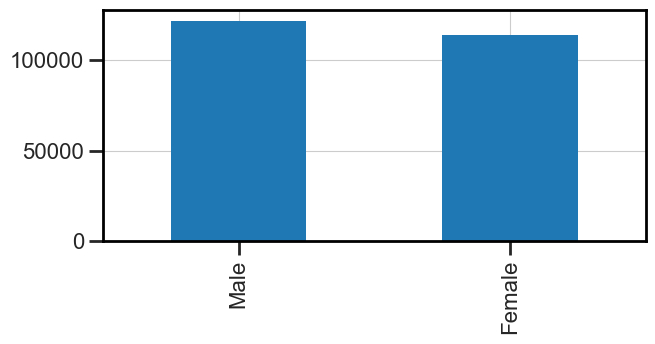

In [9]:
# Gender distribution
df["SEX"].value_counts().plot(kind="bar", figsize= (7,3))
(df["SEX"].value_counts()/df["SEX"].count())*100

White       73.181485
Black       19.034054
Asian        2.465101
Mixed        2.045843
Native       1.611748
Other        1.592671
Islander     0.069099
Name: RAC1P, dtype: float64

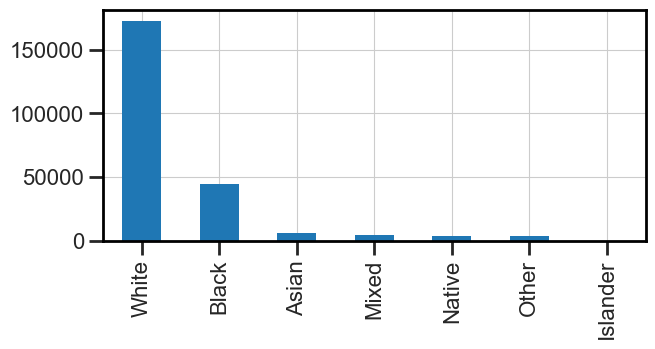

In [10]:
# Race distribution
df["RAC1P"].value_counts().plot(kind="bar", figsize= (7,3))
(df["RAC1P"].value_counts()/df["RAC1P"].count())*100

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


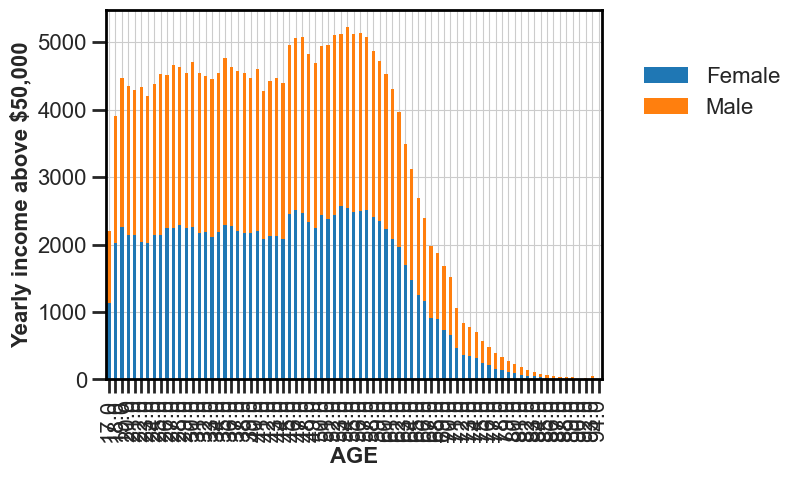

In [13]:
# Age distribution
df_ag = df.groupby(['AGEP', 'SEX'])['AGEP'].count().unstack('SEX').fillna(0)
df_ag.plot(kind='bar', stacked=True)
plt.xlabel('AGE', fontweight="bold")
plt.ylabel('Yearly income above $50,000', fontweight="bold")
plt.legend(bbox_to_anchor=(1.4, 0.9))
plt.savefig(resu_path + 'lar_distbyage.pdf', bbox_inches='tight', dpi=400)
plt.show() 

NC    50893
GA    50238
TN    33240
SC    24327
AL    22074
LA    20882
OK    17724
MS    13003
AK     3512
Name: STATE, dtype: int64


50893

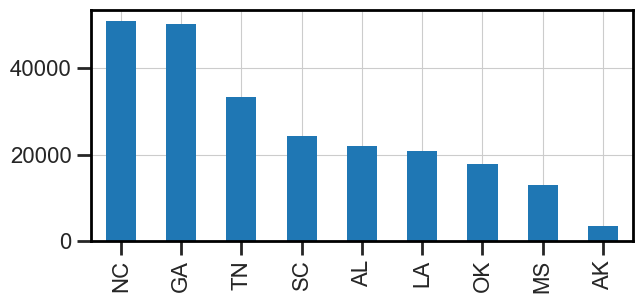

In [14]:
# Country distribution
df["STATE"].value_counts().plot(kind="bar", figsize= (7,3))
print(df["STATE"].value_counts())
df["STATE"].value_counts().max()

<AxesSubplot:>

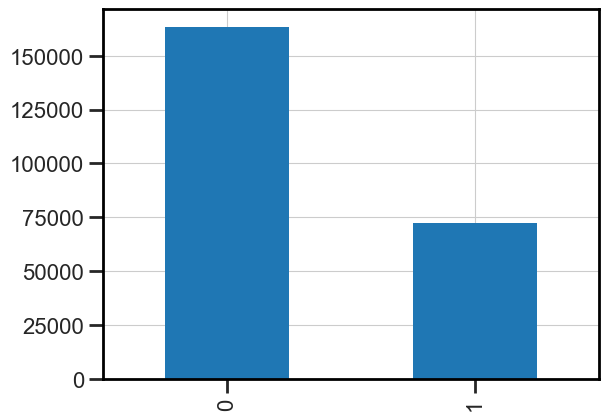

In [16]:
# Target variable distribution
df[target].value_counts()
df[target].value_counts().plot(kind='bar', stacked=True)

(Y        0     1
 AGEP            
 17.0  2199     6
 18.0  3892    13
 19.0  4455    14
 20.0  4323    29
 21.0  4244    41
 22.0  4254    82
 23.0  4028   180
 24.0  4087   294
 25.0  4024   506
 26.0  3940   580
 27.0  3908   754
 28.0  3723   913
 29.0  3578   966
 30.0  3648  1057
 31.0  3370  1181
 32.0  3299  1208
 33.0  3196  1265
 34.0  3235  1307
 35.0  3212  1562
 36.0  3108  1521
 37.0  3017  1564
 38.0  2986  1556
 39.0  2891  1577
 40.0  2965  1632
 41.0  2661  1620
 42.0  2718  1713
 43.0  2718  1749
 44.0  2717  1676
 45.0  2976  1991
 46.0  2996  2064
 47.0  3005  2076
 48.0  2811  2018
 49.0  2796  1899
 50.0  3007  1940
 51.0  2996  1963
 52.0  3046  2066
 53.0  3092  2036
 54.0  3140  2080
 55.0  3025  2097
 56.0  3066  2066
 57.0  3045  2039
 58.0  2954  1917
 59.0  2850  1870
 60.0  2745  1786
 61.0  2599  1704
 62.0  2349  1621
 63.0  2022  1471
 64.0  1877  1249
 65.0  1556  1134
 66.0  1338  1059
 67.0  1106   876
 68.0  1067   805
 69.0   926   752
 70.0   81

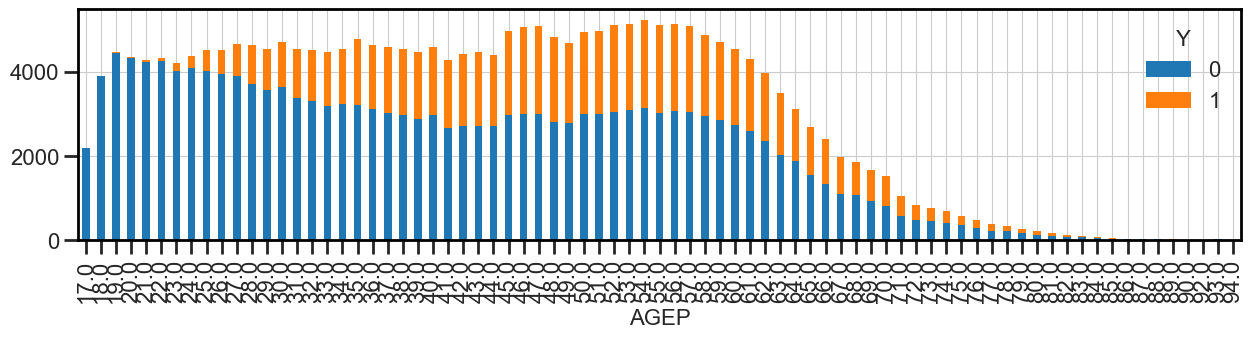

In [17]:
# Distribution of the target variable by Age,
df_ay = df.groupby(['AGEP', target])['AGEP'].count().unstack(target).fillna(0)
df_ay.plot(kind='bar', stacked=True, figsize= (15,3))
#ratio of leaving (1) employees oer age group
df_ay, (df_ay[1]/(df_ay[0]+df_ay[1])*100).sort_values()

(Y           0      1
 SEX                 
 Female  88449  25723
 Male    74985  46736,
 SEX
 Female    22.530042
 Male      38.396004
 dtype: float64)

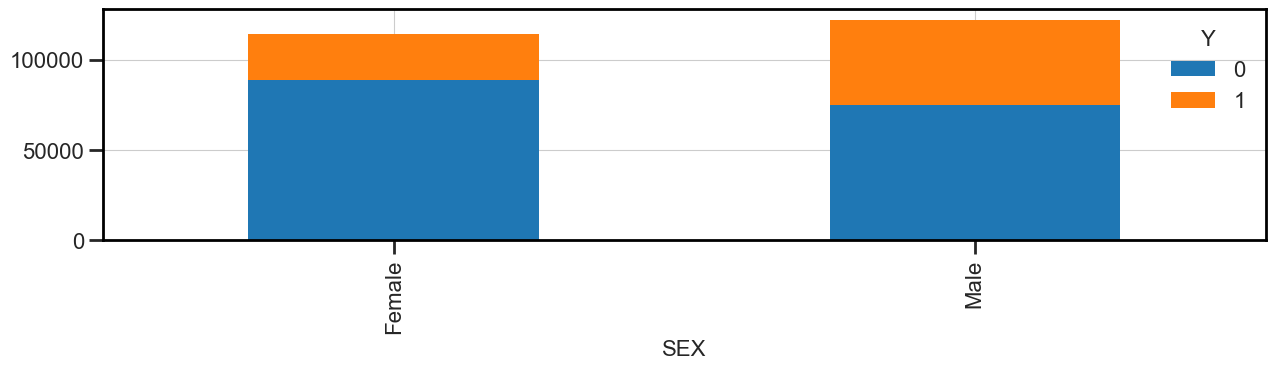

In [18]:
# Distribution of the target variable by Gender
df_gy = df.groupby(['SEX', target])['SEX'].count().unstack(target).fillna(0)
df_gy.plot(kind='bar', stacked=True, figsize= (15,3))
# Ratio of leaving (1) employees oer age group
df_gy, df_gy[1] / (df_gy[0] + df_gy[1])*100

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


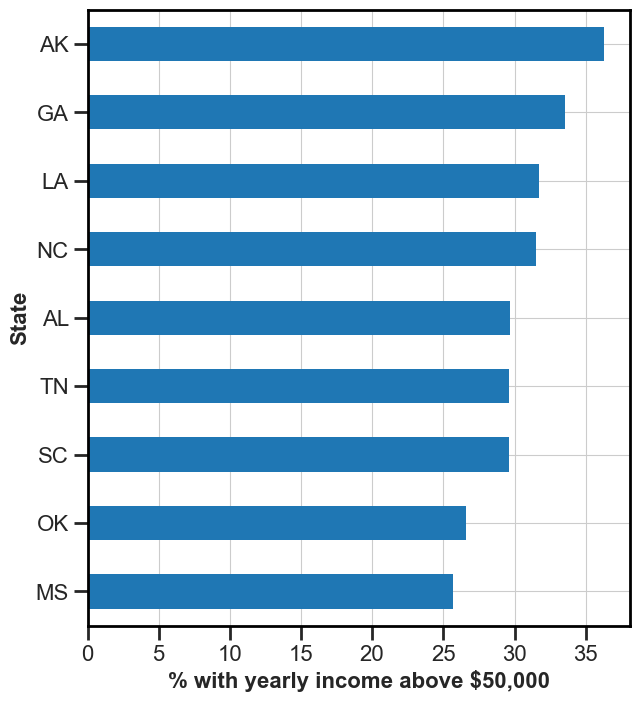

STATE
MS    25.655618
OK    26.624915
SC    29.588523
TN    29.626955
AL    29.686509
NC    31.530859
LA    31.687578
GA    33.572196
AK    36.304100
Name: Y, dtype: float64


In [19]:
# Distribution of the Y target variable per state
percs = (df.groupby('STATE')[target].mean() * 100).sort_values()
percs.plot.barh(grid = True, figsize = (7, 8))
plt.xlabel('% with yearly income above $50,000', fontweight="bold")
plt.ylabel('State', fontweight="bold")
plt.savefig(resu_path + 'lar_distbycountry.pdf', bbox_inches='tight', dpi=400)
plt.show() 
print(percs)

## Feature analysis

In [28]:
# Kruskal test
a = 'STATE'
for b in ['AGEP', 'SCHL', 'OCCP', 'MAR']:
    l = [[*v] for _, v in df[[a,b]].groupby(a)[b]]
    print(b)
    print(stats.kruskal(*l))

AGEP
KruskalResult(statistic=132.19976697139518, pvalue=9.896726030838647e-25)
SCHL
KruskalResult(statistic=1320.5311967483585, pvalue=8.575778523881577e-280)
OCCP
KruskalResult(statistic=559.6859350347287, pvalue=1.0789451698058068e-115)
MAR
KruskalResult(statistic=312.81459599523413, pvalue=7.693955953049199e-63)


meta NOT subset; don't know how to subset; dropped


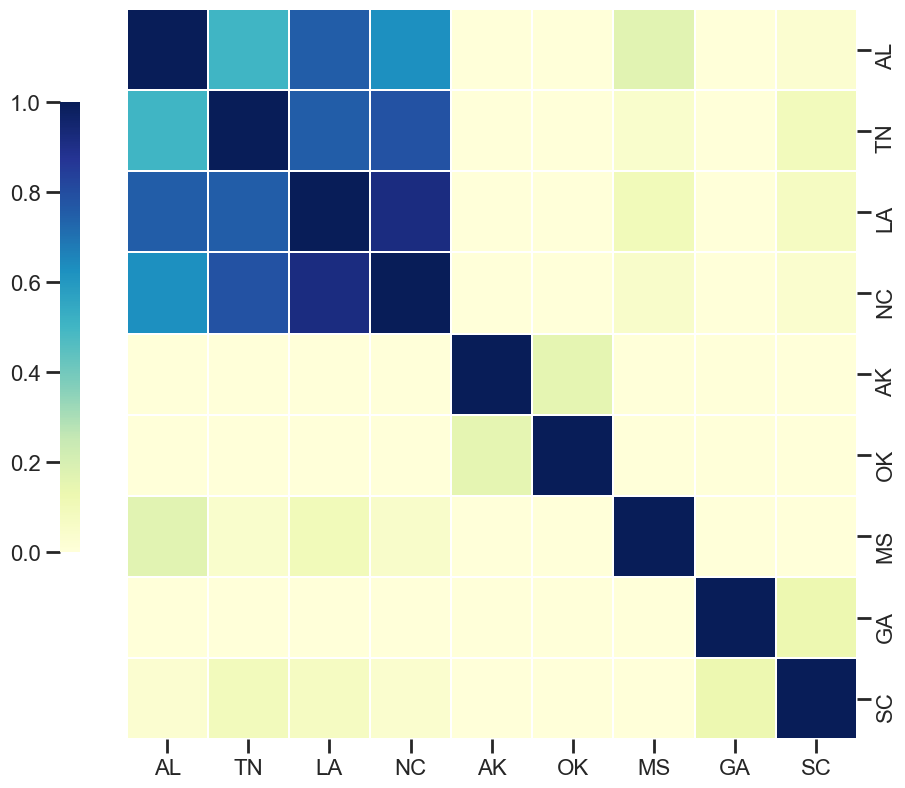

In [24]:
import scikit_posthocs as sp

# post-hoc test
pc = sp.posthoc_conover(df, val_col='AGEP', group_col=a)
cg = sns.clustermap(pc,xticklabels=True, yticklabels = True, linewidths= 0.25, cmap="YlGnBu")
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_position([.14, .25, .02, .45])
cg.cax.yaxis.set_ticks_position("left")
## plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=75) # rotate ticks - not done
plt.savefig(resu_path + 'lar_heatmap.pdf', bbox_inches='tight', dpi=400)

In [25]:
#Feature importance based on average precision of a classifier on the single feature
def test_proc(clf, X, y):
    # something close to: res =cross_val_score(clf, X, y, cv=10, scoring=score_metric)
    res_auc = res_avg = []
    for ite in range(0, 10):
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state=ite)
        for train, test in skf.split(X, y):
                X_train = X.iloc[train]
                y_train = y.iloc[train]
                X_test = X.iloc[test]
                y_test = y.iloc[test]
                clf.fit(X_train, y_train)
                y_scores = clf.predict_proba(X_test)[:,1] 
                avg_pr = average_precision_score(y_test, y_scores, sample_weight=None)
                res_avg.append(avg_pr)
                precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=None)
                auc_pr = auc(recall, precision)           
                res_auc.append(auc_pr)           
    # mean
    m = statistics.mean(res_auc)
    # standard deviation over the folds
    s = statistics.stdev(res_auc)
    # ci lower
    ci = ci_auc(res_avg, npos=sum(y))
    l = ci[2]
    u = ci[3]
    return (m, s, l, u)

In [29]:
#Feature importance using logistic regression on Theme columns
clf = LogisticRegression(solver='lbfgs', random_state=0)
roc = dict()
for b in ['AGEP', 'SCHL', 'OCCP', 'MAR']:
# for b in all_feats:
    m, s, l, u = test_proc(clf, df[[b]], df[target])
    roc[b] = (m, s, l, u)

SCHL: PR AUC=0.533 +/- 0.022 CI=(0.530, 0.535812)
OCCP: PR AUC=0.513 +/- 0.006 CI=(0.512, 0.513814)
MAR: PR AUC=0.504 +/- 0.111 CI=(0.488, 0.519400)
AGEP: PR AUC=0.403 +/- 0.004 CI=(0.403, 0.403946)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


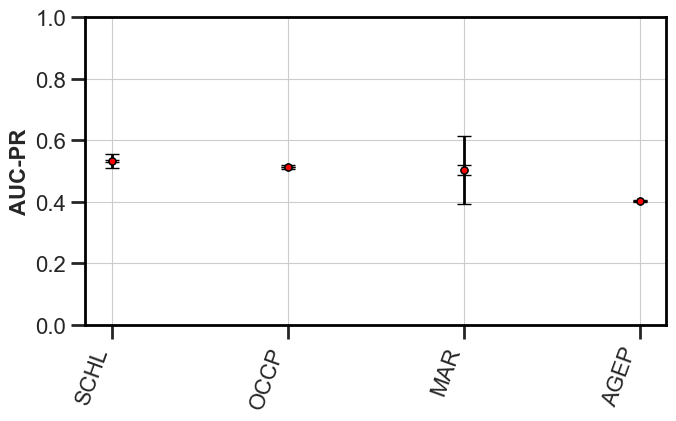

In [31]:
#Plot feature importance for themes
plt.figure(figsize=(7.5,4))
labels = []
i = 1
for b, v in sorted(roc.items(), key=lambda kv: kv[1][0], reverse=True):
    print('%s: PR AUC=%.3f +/- %.3f CI=(%.3f, %3f)' % (b, v[0], v[1], v[2], v[3]))
    plt.errorbar([i], [v[0]], yerr= [ [v[1]], [v[1]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # error bar
    plt.errorbar([i], [v[0]], yerr= [ [v[0]-v[2]], [v[3]-v[0]] ], c='black', fmt='o', mfc='red', markersize=5, capsize=5) # ci bars
    labels.append(b)
    i += 1
plt.xticks(range(1, i), labels, rotation=70, ha='right')
plt.ylabel('AUC-PR', fontweight="bold")
plt.ylim(0, 1)
plt.savefig(resu_path + 'lar_uniaucpr.pdf', bbox_inches='tight', dpi=400)

## Run experiments

In [ ]:
# set weights
weight_column = None
# weight_column = df["Weight"] 
if weight_column is not None:
    print('Positive rate', sum(weight_column[df[target]==1])/sum(weight_column))
# simulate weights for TABNET
simulate_weights = True

In [ ]:
num_repeat = 10

# Amount of trials/hyperparameter configurations per classifier
n_trials = 50

# Number of folds in StratifiedK cross-validation used when evaluating each classifier type
stratified_folds_cv = 10

# Number of cross-validation folds used when evaluating each trial within Optuna
trial_cv = 3

# Classifiers to experiment with
clf_names = ["LGBM2", 'LGBM', "LR", "RF", "DT", "XGB", "KNN", "TABNET"]

In [ ]:
import time

experiment_results = [] # store incrementally the results of experiments

for dataset_version, dataset in datasets.items():
    print('Dataset version', dataset_version)
    
    # Create our X and y from the selected dataset
    X = dataset.copy()
    y = dataset[target]
    X.drop(columns = [target], inplace = True)
    
    # Drop the correlated features
    #X = drop_correlated_features(X, .75)
       
    for rep in range(0, num_repeat):
        skf = StratifiedKFold(n_splits = stratified_folds_cv, shuffle = True, random_state=rep)
        for fold, (train, test) in enumerate(skf.split(X, y)):

            # train, test contain position based indexes of the sets
            X_train = X.iloc[train]
            y_train = y.iloc[train]
            sw_train = weight_column.iloc[train] if weight_column is not None else None

            X_test = X.iloc[test]
            y_test = y.iloc[test]
            sw_test = weight_column.iloc[test] if weight_column is not None else None
                        
            if simulate_weights:
                X_train = X_train.copy()
                X_train[target] = y_train
                wc = (sw_train/min(sw_train)).astype('int32')
                X_train = X_train.loc[X_train.index.repeat(wc)].reset_index(drop=True)
                y_train = X_train[target]
                X_train.drop(columns = [target], inplace = True)
                sw_train = None
                print(X_train.shape)

            # Try all classifiers
            for clf_name in clf_names:
                start = time.time()

                # "LGBM" is lightgbm with specialized optuna_study hyperparameter search (not included in the paper)
                # "LGBM2" is lightgbm with normal optuna_study hyperparameter search
                if clf_name == "LGBM":
                    #Hyperparameter optimization just on the trainset of the fold
                    experiment_result = optuna_study_lgbm(categorical_columns, trial_cv, X_train, y_train, sw_train)        
                else:
                    #Hyperparameter optimization just on the trainset of the fold
                    experiment_result = optuna_study_normal(clf_name, categorical_columns, trial_cv, n_trials, X_train, y_train, sw_train)

                experiment_result["dataset"] = dataset_version

                #Build the model with build_opt_clf(string, dictionary)
                clf = build_model(experiment_result['clf_name'], categorical_columns, experiment_result['best_hyparams'])

                #The model now has to learn the parameters from the training set
                if sw_train is not None:
                    clf.fit(X_train, y_train, clf__sample_weight=sw_train)
                else:
                    clf.fit(X_train, y_train)

                end = time.time()

                # Evaluate the model on the test set (not seen by optuna)
                #predict_proba returns ndarray of probs of shape (n_samples, n_classes)
                y_scores = clf.predict_proba(X_test)[:,1] 

                #AUPR curve computed using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
                #compares the ground truth with predicted probabilities     
                ap = average_precision_score(y_test, y_scores, sample_weight=sw_test)
                precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=sw_test)
                auc_pr = auc(recall, precision)

                #add to experiment_result dictionary (output of optuna_study) a new key:value pair (metric_test)
                experiment_result['fold'] = rep*stratified_folds_cv+fold
                experiment_result['auc_pr_test'] = auc_pr
                experiment_result['ap_test'] = ap
                experiment_result['elapsed'] = end - start
                #experiment_result['clf'] = clf
                experiment_result['train'] = train
                experiment_result['test'] = test

                #add the dictionary to the experiment_results list
                experiment_results.append(experiment_result)

                print(dataset_version, clf_name, 'fold', experiment_result['fold'], 'metrics', auc_pr, ap, end - start)